In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import mysql.connector
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('{}{}(t-{})'.format(df.columns[0],j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('{}{}(t+{})'.format(df.columns[0],j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))

## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, wd_on = False):
    tempcols = ['temperature','temperature.1','temperature.2','temperature.3']
    load = df['TotalLoad']
    f_temp = pd.DataFrame()
    for col in tempcols:
        temp = lag_ahead_series(df[col], 
                             n_in = 0,
                             n_out = temp_ahead + 1,
                             n_vars = 1,
                             dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)
    
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead + 1,
                          n_vars = 1,
                          dropnan = True)
                  
    if(target_ahead > temp_ahead):
        num_ahead = target_ahead
        f_temp = f_temp.iloc[load_lag:-num_ahead + temp_ahead,:]
        t = t.iloc[load_lag:,:]
    elif(target_ahead < temp_ahead):
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:-num_ahead + target_ahead,:]
    else:
        num_ahead = temp_ahead
        f_temp = f_temp.iloc[load_lag:,:]
        t = t.iloc[load_lag:,:]
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True).iloc[:-num_ahead,:]
    
    ## feature concatanation
    if wd_on:
        weekday = pd.get_dummies(df.iloc[load_lag:-num_ahead,-1])
        f = pd.concat([weekday, f_temp, f_load], axis = 1)
    else:
        f = pd.concat([f_temp, f_load], axis = 1)
    
    ## target load values
    
    
    return f, t

In [5]:
train = pd.read_csv("../data/train_elia.csv", index_col= 'time')
test = pd.read_csv("../data/test_elia.csv", index_col= 'time')

In [9]:
#                                   load_lag, target_ahead , temp_ahead, weekday_on
f_train, t_train = feature_target_construct(train, 4, 1, 0, True)

In [11]:
f_test, t_test = feature_target_construct(test, 4, 1, 0, True)

### TPOT: 6 hour ahead, 15 mins

In [17]:
from tpot import TPOTRegressor
from mmm import mul_reg_config_dict
from sklearn.model_selection import TimeSeriesSplit
#import mul_config as mc

tpot_reg = TPOTRegressor(generations=20, 
                         population_size=60,
                         offspring_size=None, 
                         mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error',
                         cv=TimeSeriesSplit(n_splits = 5),
                         subsample=1.0,n
                         n_jobs=4,
                         max_time_mins=None, 
                         max_eval_time_mins=5,
                         random_state=123, 
                         config_dict=mul_reg_config_dict,
                         template=None,
                         warm_start=False,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)

tpot_reg.fit(f_train, t_train)


Generation 1 - Current best internal CV score: -22574.1841762296
Generation 2 - Current best internal CV score: -22517.154352931953
Generation 3 - Current best internal CV score: -22517.154352931953
Generation 4 - Current best internal CV score: -22517.154352931953
Generation 5 - Current best internal CV score: -22517.154352931953
Generation 6 - Current best internal CV score: -22506.37244523898
Generation 7 - Current best internal CV score: -22506.37244523898


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, input_matrix)), bootstrap=True, max_features=0.9299999999999999, min_samples_leaf=7, min_samples_split=14, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.ensemble.ExtraTreesRegressor': {'bootstrap': [True,
                                                                                  False],
                                                                    'max_features': array([0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 , 0.33,
       0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63, 0.66,
       0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96, 0.99]),
                                                                    'min_samples_leaf': range(1, 41),
                                                                    'min_samples_split': range(2, 31),
                                                                    'n_estima...
              cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
              disable_update_check=False, early_stop=None, generations=20,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              multi_

In [18]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(f_test)

### Result Evaluation

In [19]:
get_eval(t_test, yhat)

MSE: 23788.148349196206
MAE: 114.36478837804466
r2_score: 0.9877346004788499


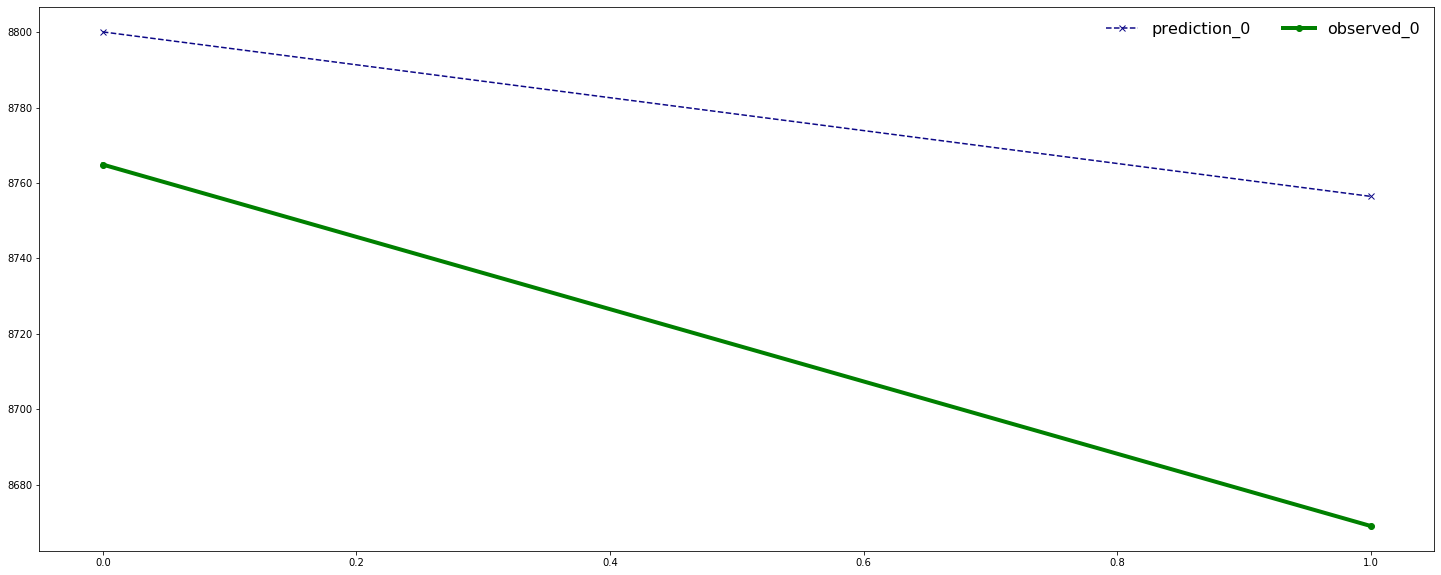

In [20]:
## assignment
real = t_test.to_numpy()
guess = yhat

real = real[1:2,:]
guess = guess[1:2,:]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### TPOT: 24 hour ahead, half-hourly

In [7]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 123)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         subsample= 0.8,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.002535817417579815
Generation 2 - Current best internal CV score: -0.002530690697956506
Generation 3 - Current best internal CV score: -0.002530690697956506
Generation 4 - Current best internal CV score: -0.002510051020902841
Generation 5 - Current best internal CV score: -0.002510051020902841
Generation 6 - Current best internal CV score: -0.002510051020902841
Generation 7 - Current best internal CV score: -0.002491375270707632
Generation 8 - Current best internal CV score: -0.0024314059283892667
Generation 9 - Current best internal CV score: -0.0023766470404857337
Generation 10 - Current best internal CV score: -0.0023766470404857337
Generation 11 - Current best internal CV score: -0.0023766470404857337
Generation 12 - Current best internal CV score: -0.0023766470404857337
Generation 13 - Current best internal CV score: -0.002355760607122987
Generation 14 - Current best internal CV score: -0.002355760607122987
Generation 15 - Current 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [8]:
yhat = tpot_reg.predict(test_X)
mean_squared_error(test_y, yhat)
mean_absolute_error(test_y, yhat)
r2_score(test_y, yhat)

0.8708304000147385

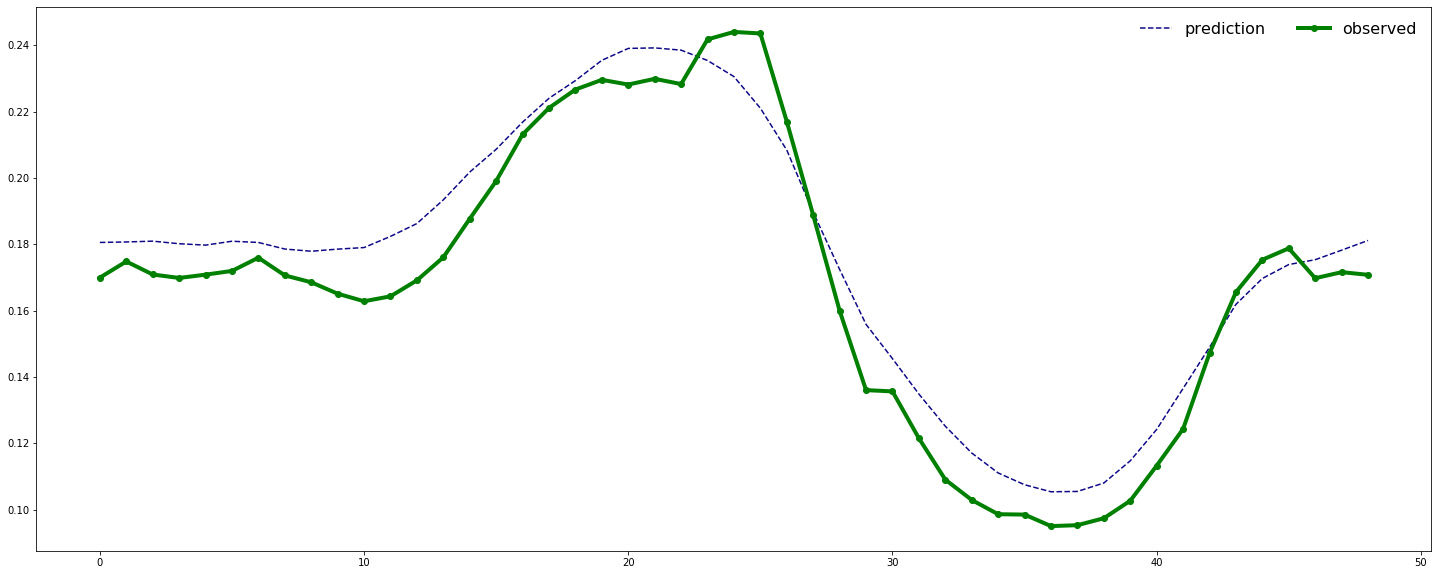

In [9]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()